# ABC with the OpenCL RAMP model

## Import modules

Note about libraries:

 - Use [pyabc](https://pyabc.readthedocs.io/) (listed in [pythonMCMC](https://gabriel-p.github.io/pythonMCMC/)).

Note about installing. It is annoying. I did: 
```
conda install mpi4py
pip install pyabc
```
but also had to follow the first proposed solution [here](https://github.com/ipython/ipyparallel/issues/349) (reinstall setuptools and numpy).

Then I got a really annoying error about "`ValueError: Cell is empty`" which happened to be a pickle problem and was resolved by installing older versions: `cloudpickle==1.4.1 distributed==2.17.0` as per [this post](https://stackoverflow.com/questions/63497235/airflow-scheduler-crashes-when-a-dag-is-run)

 - Also adapted Josie's notebook: https://github.com/Urban-Analytics/uncertainty/blob/master/hm_abc_simple_example.ipynb

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Set this to False to recalculate all results (good on HPC or whatever). 
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

# Useful for connecting to this kernel
#%connect_info

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


## Setup

### Get default params for all runs

Read the parameters file

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [2]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. You need to initilaise the model at least once to create the snapshot. The following says 'run in opencl mode and stop once initialisation has finished':

```
python microsim/main.py -ocl -init
```

In [3]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

### Observation Data

Read the real observations (number of hospital admissions in Devon) that will be used to calibrate the model. See the [README](./observation_data/README.md) for information about how these observations were obtained. They aren't the raw cases, it's actually a model that was fitted to the lagged cases. They need to be made cumulative as this is how they will be compared to the model.

In [4]:
# New per day:
gam_cases = pd.read_csv(os.path.join("../../", "gam_cases.csv"), header=0, names=["Day", "Cases"], )

# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )

assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

Total cases: 16371


### Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model

In [5]:
ITERATIONS = 100  # Number of iterations to run for
NUM_SEED_DAYS = 10  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(
    iterations = ITERATIONS, 
    repetitions = REPETITIONS, 
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS, 
    parameters_file = PARAMETERS_FILE, 
    opencl_dir = OPENCL_DIR, 
    snapshot_filepath = SNAPSHOT_FILEPATH
)

Running models: 100%|██████████| 10/10 [01:36<00:00,  9.68s/it]

.. finished, took 96.81s)
Ran Model. {} (Sum result: 1258693.4)
fitness: 34311.81513881188


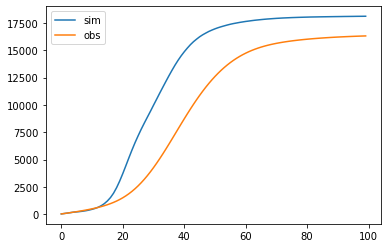

In [6]:
OpenCLRunner.update(repetitions=10)  # Temporarily use more repetitions
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)  # Temporarily use more repetitions
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim")
ax.plot(x, obs0, label="obs")
ax.legend()

### Plot output summary data

#### Total counts of disease status

In [7]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations
    
    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)
        
        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "Cases"], 
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")
        
    
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

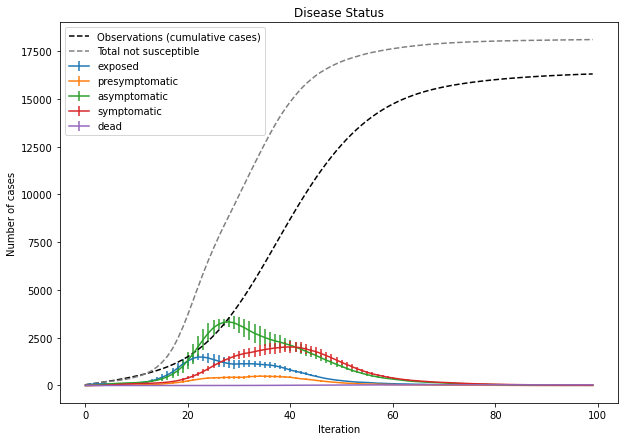

In [8]:
plot_summaries(summaries=summaries0, observations=OBSERVATIONS, plot_type="error_bars")

In [9]:
#plot_summaries(summaries=summaries0, plot_type="lines")

#### Disease statuses by age

In [10]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

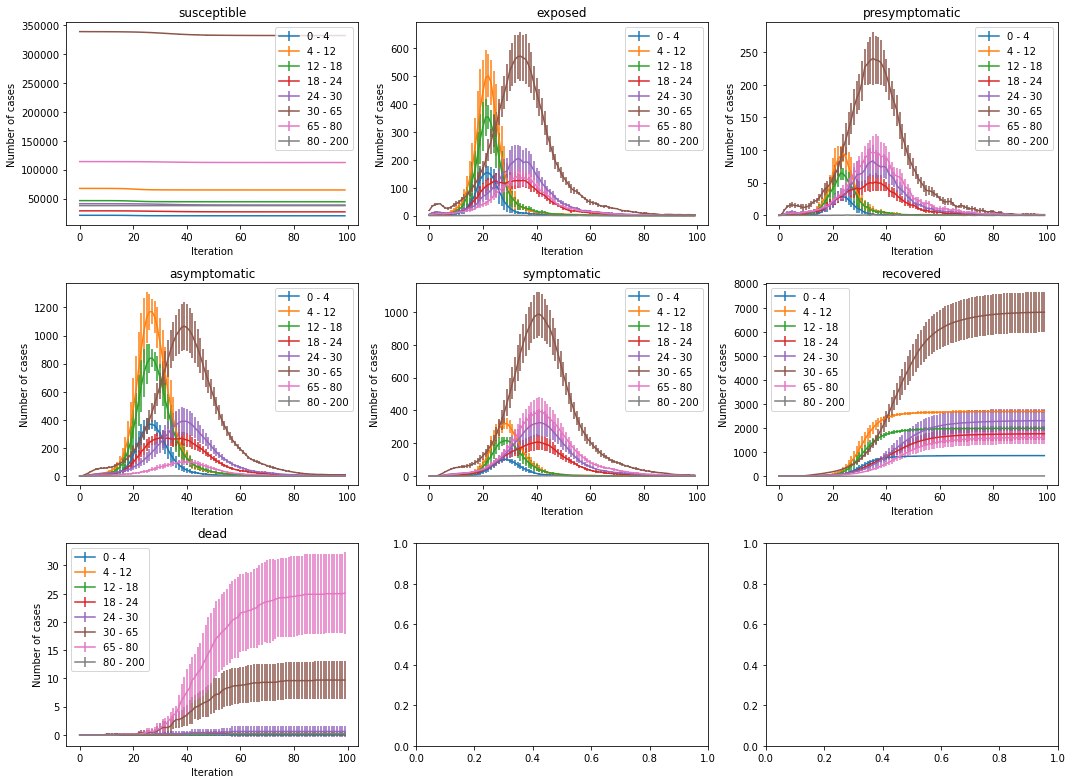

In [11]:
plot_disease_status_by_age(summaries0)

### Plot MSOA geodata

#### Load MSOA shapes

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


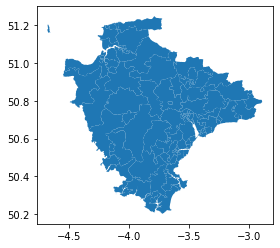

In [12]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes

data_dir = ("../../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [13]:
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

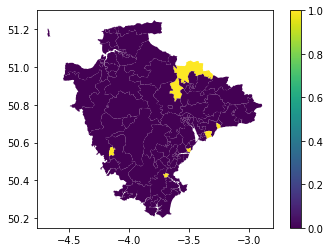

In [14]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries0[0], disease_status, 99)

## Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/) (listed in [pythonMCMC](https://gabriel-p.github.io/pythonMCMC/)).

In [15]:
# Also need a new distance function that extracts the data from dataframes.
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

### Calculating Error: Fitness Function

To calibrate the model we need a fitness function that tells us, for a given result, how similar it is to the observations. The 'observations' (in the [gam_cases.csv](../../gam_cases.csv)) are the number of new infections per day. The model equivalent of this is to look at the number of non-susceptible people per day (i.e. add up all the _non-susceptible_ disease statuses).

Ultimately two arrays showing the cumulative infections per day need to be compared. There are lots of ways to do this. For now, just take the **Euclidean distance (L2 norm)** between the observed number of cases and the simulated number of cases.

This is implemented in `opencl_runner.OpenCLRunner.fit_l2` (see [opencl_runner.py](../opencl_runner.py)).

Note that the model is seeded using the first few days of cases, so at the beginning of a run the simulated data will be identical to the observations. This doesn't matter though because the relative difference between different parameter combinations will be the same regardless.

### Priors

Define the priors. This time make them all normal distributions, but will decorate them later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

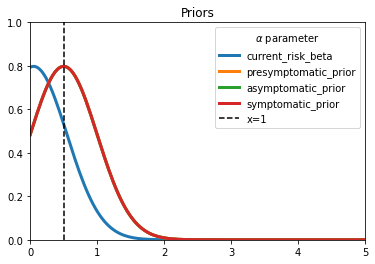

In [16]:
current_risk_beta_rv = pyabc.RV("norm", 0.05, 0.5)
presymptomatic_rv = pyabc.RV("norm", 0.5, 0.5)
asymptomatic_rv = pyabc.RV("norm", 0.5, 0.5)
symptomatic_rv = pyabc.RV("norm", 0.5, 0.5)

# Note, could create the distribution here (currently done below), then plot the priors directly using, e.g. 
#   y= p riors['current_risk_beta_prior'].pdf(x)
# but for some reason decorating them with the LowerBoundDecorator breaks the call to pdf()

x = np.linspace(-0 ,5, 150)
lines = plt.plot(x, pyabc.Distribution(param=current_risk_beta_rv).pdf({"param": x}),
                 label = "current_risk_beta", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=presymptomatic_rv).pdf({"param": x}),
                 label = "presymptomatic_prior", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=asymptomatic_rv).pdf({"param": x}),
                 label = "asymptomatic_prior", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=symptomatic_rv).pdf({"param": x}),
                 label = "symptomatic_prior", lw = 3)

plt.autoscale(tight=True)

plt.axvline(x=0.5, ls='--', color="black", label="x=1")
plt.title("Priors")
plt.ylim(0,1)
plt.legend(title=r"$\alpha$ parameter");

In [17]:
# Decorate the RVs so that they wont go below 0 and create the prior distribution 

priors = pyabc.Distribution(
    current_risk_beta = pyabc.LowerBoundDecorator(current_risk_beta_rv, 0.0),
    presymptomatic = pyabc.LowerBoundDecorator(presymptomatic_rv, 0.0),
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0),
    symptomatic = pyabc.LowerBoundDecorator(symptomatic_rv, 0.0)
    )

#current_risk_beta_prior = pyabc.LowerBoundDecorator(current_risk_beta_prior, 0.0)
#presymptomatic_prior = pyabc.LowerBoundDecorator(presymptomatic_prior, 0.0)
#asymptomatic_prior = pyabc.LowerBoundDecorator(asymptomatic_prior, 0.0)
#symptomatic_prior = pyabc.LowerBoundDecorator(symptomatic_prior, 0.0)

### Initialise the ABC algorithm.

In [18]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    )

Define observations

In [19]:
# 'Real' cumulative cases: 
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

Where to store results


In [20]:
db_path = ("sqlite:///" + os.path.join(".", "abc2.db"))

In [21]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

INFO:History:Start <ABCSMC(id=3, start_time=2020-12-01 03:25:09.646324, end_time=None)>


### Run ABC

In [22]:
history = None
fname = "./optimisation_result-abc2.pkl"

if LOAD_PICKLES:
    with open( fname, "rb" ) as f:
        history = pickle.load(f)
else:
    #history = abc.run(minimum_epsilon=.1, max_nr_populations=10)
    history = abc.run(max_nr_populations=5) 
    # The history object only works if it has the associated database too ('abc2.db')
    with open( fname, "wb" ) as f:
        pickle.dump( history, f)

### Algorithm diagnostics

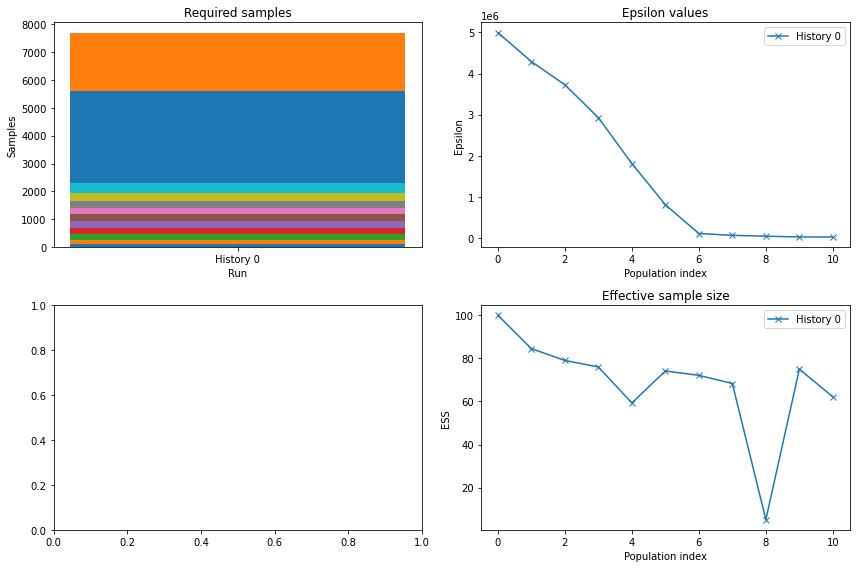

In [23]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

Plot the marginal posteriors

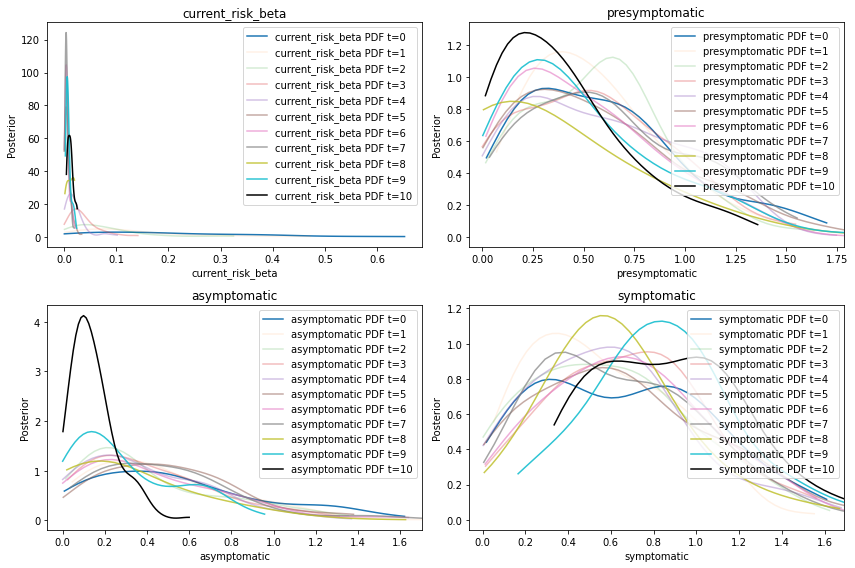

In [24]:
fig, axes = plt.subplots(2,int(len(priors)/2), figsize=(12,8))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        ) 
        ax.legend()
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
fig.tight_layout()

In [25]:
#As above, but this time do a separate plot for each population

#fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
#for t in range(history.max_t + 1):
#    ax = axes.flat[t]
#    for i, param in enumerate(priors.keys()):
#        df, w = history.get_distribution(m=0, t=t)
#        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
#            label=f"{param}")
#    ax.legend()
#    ax.set_title(f"t={t}")
# fig.tight_layout()


Now look at the 2D correlations (_I'm not sure how to read this_)

array([[<AxesSubplot:ylabel='asymptomatic'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='current_risk_beta'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='presymptomatic'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='asymptomatic', ylabel='symptomatic'>,
        <AxesSubplot:xlabel='current_risk_beta'>,
        <AxesSubplot:xlabel='presymptomatic'>,
        <AxesSubplot:xlabel='symptomatic'>]], dtype=object)

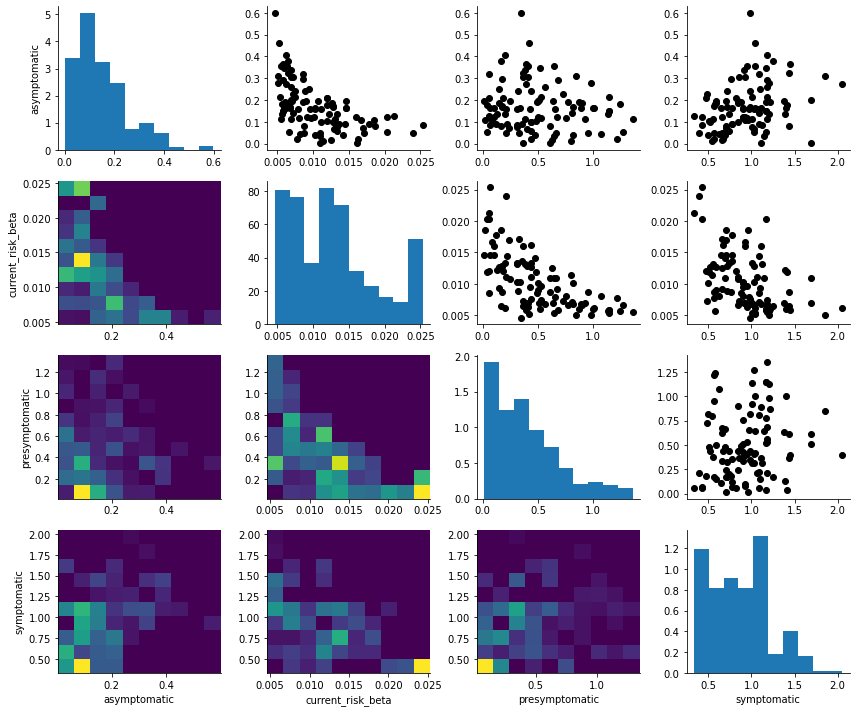

In [26]:
pyabc.visualization.plot_histogram_matrix(history, size=(12,10))

### Analyse the posterior

Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

_Note about the distrubtion returned by `get_distribution`_: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [27]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,current_risk_beta,presymptomatic,symptomatic,weight
0,999,0.498601,0.005759,0.066971,1.054343,0.024313
1,943,0.612865,0.004985,0.079190,1.000796,0.021834
2,977,0.666810,0.004586,0.157801,0.960486,0.019551
3,964,0.000434,0.012006,0.856493,0.391375,0.018896
4,942,0.009437,0.008447,1.257845,0.166386,0.018593
...,...,...,...,...,...,...
95,980,0.082267,0.019631,0.160291,0.516606,0.002070
96,958,0.142925,0.018023,0.053861,0.499519,0.001944
97,927,0.088550,0.019575,0.107069,0.655701,0.001754
98,986,0.110506,0.020075,0.002805,0.694853,0.001490


This code shows how to calculate the fitness associated with each particle (not the correct way to draw from the posterior so not especially useful).

Now we have a posterior over the parameters. There are two ways to find the 'optimal' model:

 - Find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations). This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).
 
 - Sample from the posterior distribution N times (N=100?) to generate a posterior over the model outputs. This better captures the uncertainty in the parameter values and in the associated model outputs.


#### ABC Posterior (A) - Find the Mode(s)

XXXX - Just get the marginal probabilities?

#### ABC Posterior (B) - Sample

Sample from the distribution of parameter posteriors to generate a distribution over the mode likely model results. Use kernel density approximation to randomly draw some equally weighted samples.

(This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model).

In [28]:
N_samples = 100
df, w = history.get_distribution(m=0, t=history.max_t)

# Sample from the dataframe of posteriors using KDE
# XX I don't think the KDE is a good fit at all because the samples are very poor, need to look into this
#kde = MultivariateNormalTransition(scaling=1)
#kde.fit(df, w)
#samples = kde.rvs(N_samples)

# Instead sample just using the weights (this isn't the best way to do it though, should use KDE)
df = df.reset_index()  # So that the row index is 0-N (currently it's something else)
sample_idx = np.random.choice(
            a=range(history.get_nr_particles_per_population().values[-1]),
            size=N_samples, replace=True, p=w)
samples = df.iloc[sample_idx] 

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters used in each sample
summaries_l = []  # The symmaries objects

for i, sample in samples.iterrows():

    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        print("Found negatives. Resampling")
        sample = kde.rvs()
        
    # Create a dictionary with the parameters and their values for this sample
    param_values = { param:sample[str(param)] for param in priors}
    
    # Run the model
    (_fitness, _sim, _obs, _out_params, _summaries) = \
          OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    #print(f"Fitness: {_fitness}. Sample: {sample}")
    
    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    summaries_l.append(_summaries)

# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])

Running models: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

.. finished, took 13.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.006080907776493408, 'presymptomatic': 0.30548575284309254, 'asymptomatic': 0.4922435451752884, 'symptomatic': 0.5296514213836875} (Sum result: 1776592.3999999997)
Fitness: 89340.92762871897.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]

.. finished, took 14.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.00532222290012368, 'presymptomatic': 0.33296464291986394, 'asymptomatic': 0.5173392976719686, 'symptomatic': 1.0233562312114504} (Sum result: 1736325.8000000005)
Fitness: 85311.37309972217.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]

.. finished, took 13.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.023847487328729305, 'presymptomatic': 0.06869951487292247, 'asymptomatic': 0.04614367342385019, 'symptomatic': 0.788823536680454} (Sum result: 1264192.3999999997)
Fitness: 34537.21736735604.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

.. finished, took 13.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.006739134813804514, 'presymptomatic': 0.360534541553886, 'asymptomatic': 0.3617838685167336, 'symptomatic': 0.69273360774387} (Sum result: 1381437.5999999994)
Fitness: 45948.26664195288.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

.. finished, took 13.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.005948458973551727, 'presymptomatic': 0.604799384376554, 'asymptomatic': 0.34620112461937824, 'symptomatic': 0.9165312640694355} (Sum result: 1637918.4)
Fitness: 75122.62194545662.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]

.. finished, took 13.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007295361617738952, 'presymptomatic': 0.7450790631881867, 'asymptomatic': 0.1811946031631058, 'symptomatic': 1.0079831721926586} (Sum result: 1513140.5999999999)
Fitness: 61337.44197665893.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]

.. finished, took 13.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.002777413403816721, 'presymptomatic': 1.101727035663013, 'asymptomatic': 0.8009427881238427, 'symptomatic': 1.7432381603065907} (Sum result: 1442881.7999999996)
Fitness: 52979.534699353484.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]

.. finished, took 13.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0057589424458526495, 'presymptomatic': 0.06697061138595217, 'asymptomatic': 0.4986006646569794, 'symptomatic': 1.0543430298875356} (Sum result: 1290708.6)
Fitness: 35814.0750566031.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]

.. finished, took 13.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0103114104607361, 'presymptomatic': 0.11464230916492352, 'asymptomatic': 0.2566987249141066, 'symptomatic': 0.7362637155766718} (Sum result: 1418443.9999999995)
Fitness: 49225.74334674897.


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]

.. finished, took 13.25s)
Ran Model. {'current_risk_beta': 0.012529276048542641, 'presymptomatic': 0.6579995037429975, 'asymptomatic': 0.017634813716039935, 'symptomatic': 0.7019674828083267} (Sum result: 1428616.4000000001)
Fitness: 52894.53875741804.


Plot the individual results for each sample

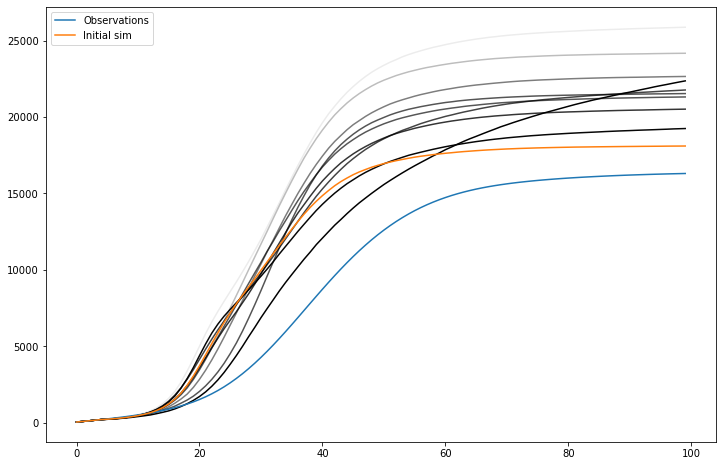

In [29]:
#print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")

# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness-min(_fitness))/(max(_fitness)-min(_fitness))

fig, ax = plt.subplots(1,1, figsize=(12,8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            #label=f"Particle {df.index[sample_idx[i]]}", 
            color="black", alpha = 1-fitness_norm[i]  # (1-x because high fitness is bad)
    )
    
    #ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    #ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
ax.plot(x, obs_l[0], label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
ax.legend()
#plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)

del _fitness, fitness_norm

Plot the kde of the sample results (a bit like the posterior?). See the [pygam documentation](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html) for the GAM code to do this

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


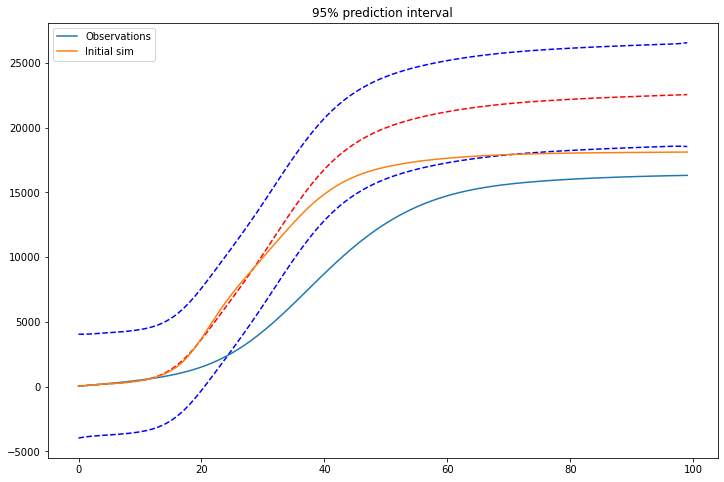

In [32]:
# Make two long arrays with every result from every particle
x = list(range(len(sim_l[0])))  # List of iteration numbers
X = []
for _iter in x * len(summaries_l):  # One sequence of iterations (0-100) for each particle
    X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
X = np.array(X)
y = []
for i in range(len(summaries_l)):
    y += list(OpenCLRunner.get_cumulative_new_infections(summaries_l[i]))
y = np.array(y)

# Generate the GAM
gam = LinearGAM( n_splines=250)
#gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
gam.gridsearch(X, y)
#XX = gam.generate_X_grid(term=0, n=len(X))
XX = gam.generate_X_grid(term=0)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(XX, gam.predict(XX), 'r--')
ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

#pdep, confi = gam.partial_dependence(term=0, width=.95)
#ax.plot(XX, pdep)
#ax.plot(XX, confi, c='r', ls='--')

ax.plot(x, obs_l[0], label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('95% prediction interval');

XXXX PLOT SOME OF THE RESULTS IN A MAP

disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries0[0], disease_status, 99)